### Visualize ccgp of feature beliefs

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy

In [2]:
SAM_PAIRS_PATH = "/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle"
pairs = pd.read_pickle(SAM_PAIRS_PATH).reset_index(drop=True)


In [8]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "pref"
args.sig_unit_level = "belief_partition_95th"
args.trial_event = "FeedbackOnsetLong"

res = belief_partitions_io.read_ccgp_results(args, pairs, conds=["within_cond", "across_cond"])

across_dim_res = belief_partitions_io.read_ccgp_results(args, pairs[pairs.dim_type == "across dim"], conds=["within_cond", "across_cond"], num_shuffles=10)
across_dim_res["type"] = across_dim_res.condition + " across dim"

within_dim_res = belief_partitions_io.read_ccgp_results(args, pairs[pairs.dim_type == "within dim"], conds=["within_cond", "across_cond"], num_shuffles=10)
within_dim_res["type"] = within_dim_res.condition + " within dim"

dim_res = pd.concat((across_dim_res, within_dim_res))


Warning, shuffle not found: /data/patrick_res/belief_partitions/SA_FeedbackOnsetLong_Response_Correct_Choice_Chose_belief_partition_95th_units/shuffles/CIRCLE_RIPPLE_pref_shuffle_3_within_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/belief_partitions/SA_FeedbackOnsetLong_Response_Correct_Choice_Chose_belief_partition_95th_units/shuffles/CIRCLE_RIPPLE_pref_shuffle_3_across_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/belief_partitions/SA_FeedbackOnsetLong_Response_Correct_Choice_Chose_belief_partition_95th_units/shuffles/CIRCLE_RIPPLE_pref_shuffle_4_within_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/belief_partitions/SA_FeedbackOnsetLong_Response_Correct_Choice_Chose_belief_partition_95th_units/shuffles/CIRCLE_RIPPLE_pref_shuffle_4_across_cond_accs.npy
Warning, shuffle not found: /data/patrick_res/belief_partitions/SA_FeedbackOnsetLong_Response_Correct_Choice_Chose_belief_partition_95th_units/shuffles/CIRCLE_RIPPLE_pref_shuffle_9_within_cond

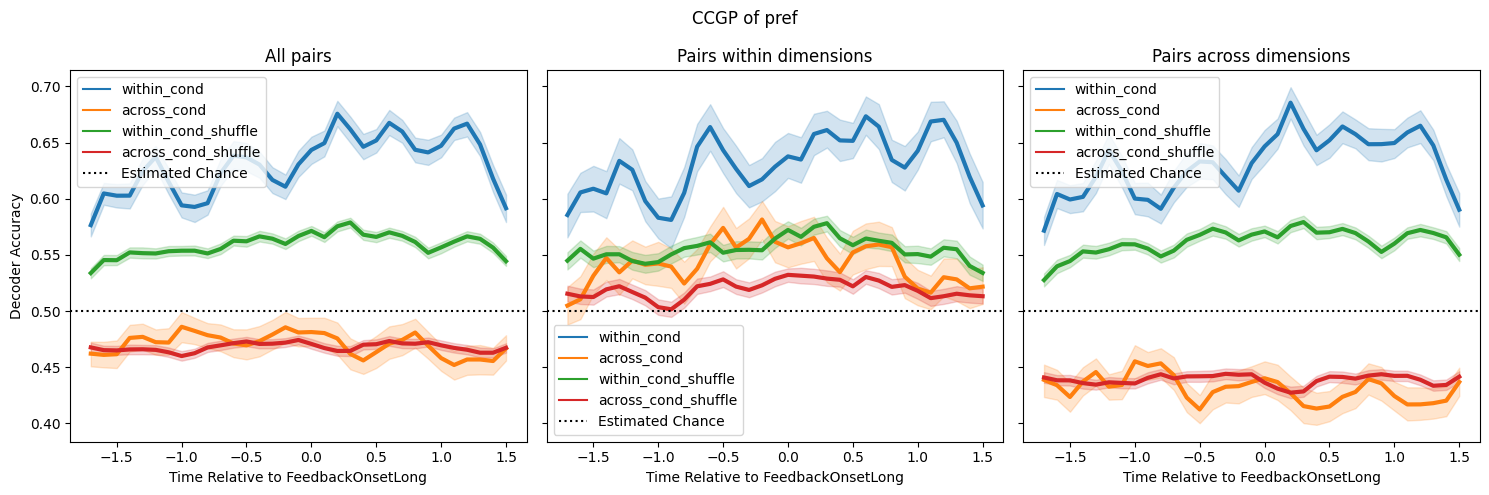

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

visualization_utils.visualize_ccpg_value(args, res, ax1)
ax1.set_title("All pairs")
visualization_utils.visualize_ccpg_value(args, within_dim_res, ax2)
ax2.set_title("Pairs within dimensions")
visualization_utils.visualize_ccpg_value(args, across_dim_res, ax3)
ax3.set_title("Pairs across dimensions")

fig.suptitle(f"CCGP of {args.mode}")
fig.tight_layout()


In [10]:
# args = argparse.Namespace(
#     **BeliefPartitionConfigs()._asdict()
# )
# args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
# args.mode = "feat_belief"
# args.sig_unit_level = "belief_pref_95th"
models = belief_partitions_io.read_ccgp_models(args, pairs)
models["weights"] = models.apply(lambda x: x.models.coef_[0, :], axis=1)
weights = models[["Time", "pair", "feat", "run", "weights"]]

In [11]:
across_res = []
within_res = []
for i, row in pairs.iterrows():
    pair_weights = weights[weights.pair.apply(lambda x: x == row.pair)]
    weights_feat_1 = pair_weights[pair_weights.feat == row.pair[0]]
    weights_feat_2 = pair_weights[pair_weights.feat == row.pair[1]]
    sim_res = classifier_utils.get_cross_cond_cosine_sim_of_weights(weights_feat_1, weights_feat_2, merge_on=["Time"])
    sim_res["pair_str"] = sim_res.pair_x.apply(lambda x: "_".join(x))
    if row.dim_type == "across dim":
        across_res.append(sim_res)
    else:
        within_res.append(sim_res)
across_res = pd.concat(across_res)
across_res["dim_type"] = "across"
within_res = pd.concat(within_res)
within_res["dim_type"] = "within"
dim_sim_res = pd.concat([across_res, within_res])


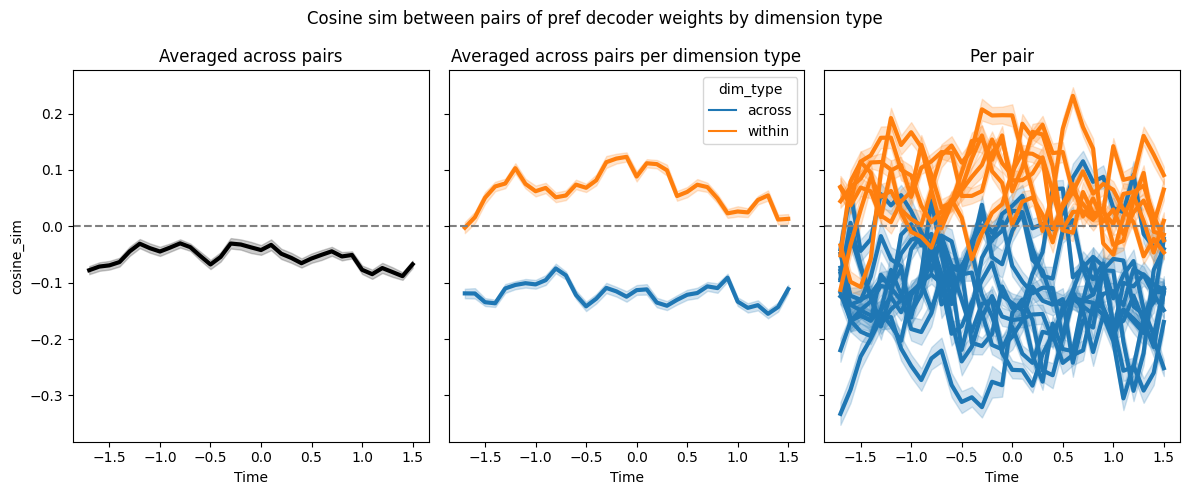

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), sharey=True)


sns.lineplot(dim_sim_res, x="Time", y="cosine_sim", linewidth=3, ax=ax1, color="black")
ax1.axhline(0, linestyle="--", color="grey")
ax1.set_title("Averaged across pairs")

sns.lineplot(dim_sim_res, x="Time", y="cosine_sim", hue="dim_type", linewidth=3, ax=ax2)
ax2.axhline(0, linestyle="--", color="grey")
ax2.set_title("Averaged across pairs per dimension type")

palette = sns.color_palette(['tab:blue'], len(across_res['pair_str'].unique()))
sns.lineplot(across_res, x="Time", y="cosine_sim", hue="pair_str", linewidth=3, ax=ax3, palette=palette, legend=False)

palette = sns.color_palette(['tab:orange'], len(within_res['pair_str'].unique()))
sns.lineplot(within_res, x="Time", y="cosine_sim", hue="pair_str", linewidth=3, ax=ax3, palette=palette, legend=False)
ax3.axhline(0, linestyle="--", color="grey")
ax3.set_title("Per pair")


fig.suptitle(f"Cosine sim between pairs of {args.mode} decoder weights by dimension type")
fig.tight_layout()